In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

    100% |████████████████████████████████| 122kB 3.4MB/s ta 0:00:01
  Found existing installation: fastai 1.0.36.post1
    Uninstalling fastai-1.0.36.post1:
      Successfully uninstalled fastai-1.0.36.post1
    100% |████████████████████████████████| 519.5MB 83kB/s  eta 0:00:01   10% |███▌                            | 56.1MB 37.9MB/s eta 0:00:13    13% |████▏                           | 67.9MB 34.1MB/s eta 0:00:14    23% |███████▍                        | 119.5MB 35.4MB/s eta 0:00:12    28% |█████████▏                      | 149.3MB 36.1MB/s eta 0:00:11    29% |█████████▍                      | 153.2MB 34.4MB/s eta 0:00:11    38% |████████████▍                   | 201.4MB 37.5MB/s eta 0:00:09    55% |█████████████████▉              | 289.2MB 35.8MB/s eta 0:00:07    58% |██████████████████▉             | 305.7MB 37.5MB/s eta 0:00:06    81% |██████████████████████████      | 421.9MB 34.4MB/s eta 0:00:03    82% |██████████████████████████▍     | 427.5MB 34.8MB/s eta 0:00:03    85% |████

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

torch.cuda.set_device(0)

In [3]:
PATH = "../input"
sz=224

In [4]:
os.listdir(PATH)

['train', 'test', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv']

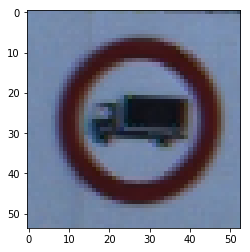

In [5]:
img = plt.imread(f'{PATH}/test/00000.png')
plt.imshow(img);

In [6]:
img.shape

(54, 53, 3)

In [7]:
import pathlib
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), val_name='train')# using training data as validation data, cause we have samller dataset.
data.path = pathlib.Path('.')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 63636244.02it/s]


  0%|          | 0/613 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 613/613 [03:37<00:00,  3.55it/s]


epoch      trn_loss   val_loss   accuracy                    
    0      0.900934   0.536752   0.842434  
    1      0.700777   0.369351   0.894284                    



[0.36935147393020074, 0.8942844754893917]

In [8]:
lrf=learn.lr_find()

 80%|████████  | 492/613 [00:08<00:02, 56.23it/s, loss=2.39] 


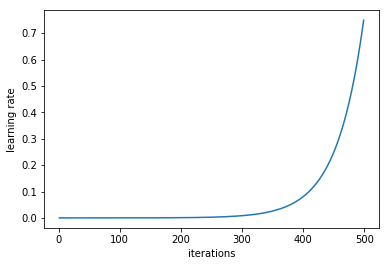

In [9]:
learn.sched.plot_lr()

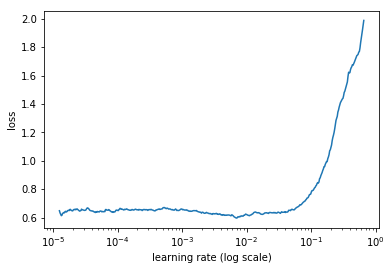

In [10]:
learn.sched.plot()

Trying to improve with data augmentation

In [11]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on)
data = ImageClassifierData.from_paths(PATH, bs=32, tfms=tfms, num_workers=1, val_name='train')
data.path = pathlib.Path('.')

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [15]:
learn.fit(1e-2, 4)

epoch      trn_loss   val_loss   accuracy                       
    0      0.598569   0.249571   0.927517  
    1      0.524158   0.200332   0.942819                       
    2      0.491744   0.174583   0.952409                       
    3      0.467785   0.153321   0.957408                       



[0.15332108465313574, 0.9574077380193323]

In [ ]:
learn.precompute = False
learn.unfreeze()
lr=np.array([1e-6,1e-4,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)